# Исследование надежности заемщиков

## Введение

Цель проекта состоит в установлении зависимости между семейным положением и количеством детей клиента банка и фактом погашения кредита в срок. Полученные выводы будут учтены при построении модели кредитного скоринга.

Для анализа предоставлена статистика, содержащая следующую информацию о заемщиках:
- `children` — количество детей в семье
- `days_employed` — общий трудовой стаж в днях
- `dob_years` — возраст клиента в годах
- `education` — уровень образования клиента
- `education_id` — идентификатор уровня образования
- `family_status` — семейное положение
- `family_status_id` — идентификатор семейного положения
- `gender` — пол клиента
- `income_type` — тип занятости
- `debt` — имел ли задолженность по возврату кредитов
- `total_income` — ежемесячный доход
- `purpose` — цель получения кредита

In [1]:
# Импорт используемых библиотек
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

## Обзор данных

In [2]:
# Загрузка данных:
try:
    data = pd.read_csv('/datasets/data.csv')
except:
    data = pd.read_csv('datasets/data_first.csv')

# Общая информация:
display(data.head(10))
print(data.info())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
None


**Наблюдения:**
- В предоставленных данных имеется ок. 21,5 тыс. наблюдений, в данных присутствуют пропуски.
- В колонке с образованием клиента есть неявные дубликаты (различное написание одного и того же), однако колонка с идентификатором уровня образования устраняет эту проблему.
- Данные о трудовом стаже и общем доходе представлены с избыточной точностью (можно перевести в целочисленный тип для экономи памяти).
- В колонке "цель кредита" присутствуют неявные дубликаты (разные формулировки одной и той же цели).

Для дальнейшего анализа необходимо провести предобработку данных.

## Предобработка данных

### Удаление пропусков

Рассмотрим число пропусков в данных по полям:

In [3]:
round(data.isna().sum() / len(data) * 100, 3)

children             0.0
days_employed       10.1
dob_years            0.0
education            0.0
education_id         0.0
family_status        0.0
family_status_id     0.0
gender               0.0
income_type          0.0
debt                 0.0
total_income        10.1
purpose              0.0
dtype: float64

Пропуски есть в двух столбцах (10% от выборки) — `days_employed` и `total_income`. Возможно, получится восстановить пропущенные значения на основании других имеющихся данных, например, типе занятости. Рассмотрим медианные значения дохода и стажа в зависимости от типа занятости:

In [4]:
data.pivot_table(index = 'income_type', values = ['total_income', 'days_employed'], aggfunc='median')

,days_employed,total_income
income_type,,
безработный,366413.652744,131339.751676
в декрете,-3296.759962,53829.130729
госслужащий,-2689.368353,150447.935283
компаньон,-1547.382223,172357.950966
пенсионер,365213.306266,118514.486412
предприниматель,-520.848083,499163.144947
сотрудник,-1574.202821,142594.396847
студент,-578.751554,98201.625314


Видим, что медианные значения для стажа и дохода действительно разнятся в зависимости от типа занятости. Таким образом, предлагается заполнить пропущенные значения медианами по своему типу занятости.

Заметим, что медианы для стажа отрицательны для всех категорий, кроме безработных и пенсионеров. При этом по модулю стаж безработных и пенсионеров в сотни раз больше, чем для остальных типов занятости. Эти аномалии будут обработаны позднее.

In [5]:
# Заполняем пропуски:
for t in data['income_type'].unique():
    # Общих доход:
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()
    # Общий стаж:
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

### Обработка аномальных значений

Как было замечено ранее, медианные значения для стажа были отрицательны. Рассмотрим распределение стажа, чтобы выяснить, как лучше устранить аномалию:

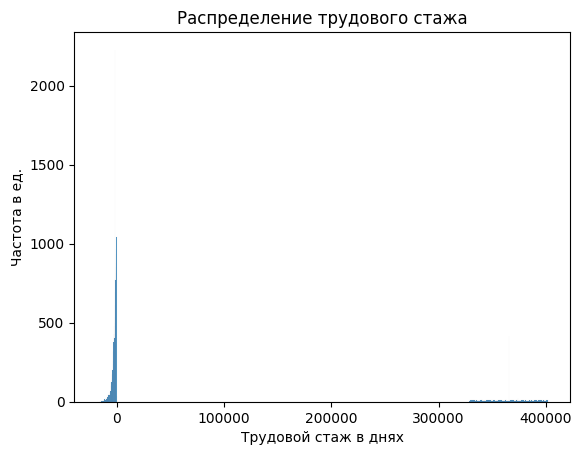

In [6]:
sbn.histplot(data = data,
            x='days_employed')
plt.ylabel('Частота в ед.')
plt.xlabel('Трудовой стаж в днях')
plt.title('Распределение трудового стажа')
plt.show()

Распределение не очень показательное из-за больших значений бля пенсионеров и безработных, однако можно заметить, что все значения для остальных категорий отрицательны. Поэтому можно заменить их абсолютным значением. Для аномально больших по модулю значений стажа среди пенсионеров и безработных сложно предложить разумный вариант устранения (неизвестно, что привело к возникновению проблемы), поэтому оставим эти значения как есть.

In [7]:
# Меняем знак на трудовом стаже:
data['days_employed'] = data['days_employed'].abs()

Рассмотрим остальные столбцы на предмет аномальных значений:

In [8]:
cols_to_analyse = ['children', 
                   'education',
                   'education_id', 
                   'family_status',
                   'family_status_id',
                   'gender', 
                   'debt',
                   'purpose']
for i in cols_to_analyse:
    print('Уникальные значения в колонке', i)
    print(data[i].unique())
    print('-------------------------------')

Уникальные значения в колонке children
[ 1  0  3  2 -1  4 20  5]
-------------------------------
Уникальные значения в колонке education
['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']
-------------------------------
Уникальные значения в колонке education_id
[0 1 2 3 4]
-------------------------------
Уникальные значения в колонке family_status
['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']
-------------------------------
Уникальные значения в колонке family_status_id
[0 1 2 3 4]
-------------------------------
Уникальные значения в колонке gender
['F' 'M' 'XNA']
-------------------------------
Уникальные значения в колонке debt
[0 1]
-------------------------------
Уникальные значения в колонке purpose
['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 

- Заметим, что в столбце `children` есть два аномальных значения (-1 и 20). Найдем их долю:

In [9]:
data['children'].value_counts(normalize=True)*100

 0     65.732869
 1     22.383275
 2      9.547038
 3      1.533101
 20     0.353078
-1      0.218351
 4      0.190476
 5      0.041812
Name: children, dtype: float64

В совокупности число аномалий не превышет 1% от выборки, удалим такие значения.

In [10]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

- Несмотря на различное написание, число категорий в уровне образования и в идентификаторе уровня образования совпадают, т.е. при необходимости можно ориентироваться на идентификатор.
- Проблем в категориях семейного положения нет.
- Приустствует странное значение в коолонке пола. Найдем долю наблюдений с таким признаком:

In [11]:
data['gender'].value_counts(normalize=True)*100

F      66.134006
M      33.861321
XNA     0.004672
Name: gender, dtype: float64

Количество таких наблюдений мизерно, удалим их из датасета.

In [12]:
data = data[data['gender'] != 'XNA']

- Значения в колонке `debt` только 0 и 1, т.е. фиксируется не количество просрочек, а только факт их допущения.
- Среди целей получения кредита много разных формулировок для одной и той же цели; можно ввести катгоризацию для упрощения анализа.

### Изменение типов данных

Ранее было замечено, что данные о трудовом стаже и общем доходе представлены с избыточной точностью. Переведем их в целочисленный тип для экономии памяти:

In [13]:
data['total_income'] = data['total_income'].astype(int)
data['days_employed'] = data['days_employed'].astype(int)

### Обработка дубликатов

Ранее отметили, что в колонке с уровнем образования присутствуют неявные дубликаты (написание со строчной/заглавной буквы). Унифицируем написание признаков:

In [14]:
data['education'] = data['education'].str.lower()

Теперь проверим датасет на наличие полных дубликатов в записях:

In [15]:
data.duplicated().sum()

71

Удалим явыные дубликаты:

In [16]:
data = data.drop_duplicates()

### Категоризация данных

Для упрощения анализа категоризируем некоторые данные. Создадим столбец `total_income_category` с категориями:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [17]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [18]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Также объединим цели кредитов в категории  на основании данных из столбца `purpose`. Сформируем новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [19]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [20]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Исследовательский анализ

### Зависимость между количеством детей и возвратом кредита в срок

**Гипотеза**

Гипотетически вероятность допустить просрочку по кредиту должна увеличиваться по мере роста количества детей у заемщика, поскольку при прочих равных получаемый доход распределяется на все большее количество членов семьи, увеличивается риск непредвиденных трат и т.д. (Гипотеза основана на допущении, что отсутствует зависимость между уровнем дохода и количеством детей в семье).

**Анализ**

Рассмотрим данные по средней доле заемщиков с просрочкой по кредиту в разрезе количества детей:

,Кол-во детей у заемщика,Кол-во наблюдений,"Доля заемщиков с просрочкой, %"
0,0,14090,7.544
1,1,4808,9.235
2,2,2052,9.454
3,3,330,8.182
4,4,41,9.756
5,5,9,0.000


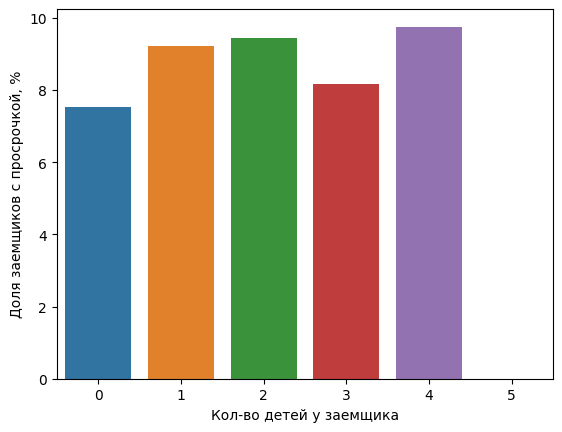

In [21]:
# получим сводные данные:
pivot = data.pivot_table(values='debt',index='children',aggfunc=['count','mean'])
# создадим таблицу для визуализации:
# (я не поняла, как переименовать столбцы в "человеческий" формат в pivot_table, 
# подскажите, пожалуйста, как это сделать правильно)
debt_by_children = pd.DataFrame(index=pivot.index)
debt_by_children['Кол-во детей у заемщика'] = pivot.index
debt_by_children['Кол-во наблюдений'] = pivot['count']
debt_by_children['Доля заемщиков с просрочкой, %'] = round(pivot['mean']*100, 3)
display(debt_by_children.reset_index(drop=True))

# рассмотрим распределение полученных значений:
sbn.barplot(x='Кол-во детей у заемщика', 
            y='Доля заемщиков с просрочкой, %', 
            data=debt_by_children);

Данные говорят о том, что:

- Подавляющее большинство заемщиков (более 50%) не имеют детей. Количество заемщиков с детьми кратно сокращается по мере увеличения количества детей, доля заемщиков с четырьмя и пятью детьми в выборке ничтожна (в совокупности менее 1%).

- Доля заемщиков с просрочкой колеблется в зависимости от количества детей (см. график выше), четкой линейной зависимости между показателями не наблюдается. Кроме того, данные для заемщиков с четырьмя и пятью детьми могут быть нерепрезентативны из-за малого количества наблюдений. Однако можно заметить, что доля бездетных заемщиков с просрочкой (7,5%) ниже, чем у заемщиков с детьми (8,2-9,8%).

Рассчитаем долю просрочки в целом по заемщикам, у которых есть дети.

In [22]:
# создадим функцию, конвертирующую количество детей в факт их наличия/отсутствия:
def categorize_children(number):
    if number == 0:
        return 'нет детей'
    elif number > 0:
        return 'есть дети'
    else:
        return 'проверить данные'
    
# применим функцию к данным:
data['children_category'] = data['children'].apply(categorize_children)

# получим сводные данные в разрезе наличия детей:
pivot = data.pivot_table(values='debt',index='children_category',aggfunc=['count','mean'])
no_kids = pivot['mean'].values[1,0]
has_kids = pivot['mean'].values[0,0]

try:
    print(f'Доля просрочек по кредиту среди заемщиков без детей: {no_kids:.3%}')
    print(f'Доля просрочек по кредиту среди заемщиков с детьми: {has_kids:.3%}')
except:
    print('Ошибка, проверить данные сводной таблицы')

Доля просрочек по кредиту среди заемщиков без детей: 7.544%
Доля просрочек по кредиту среди заемщиков с детьми: 9.240%


Видим, что доля просрочек среди заемщиков, у которых есть дети, составила 9,2%, что в целом выше, чем у бездетных заемщиков (7,5%).

**Вывод**

- Согласно данным, заемщик без детей с большей вероятностью вернет кредит в срок, чем заемщик, у которого есть дети. Такой вывод может быть обусловлен тем, что наличие детей приводит к бОльшим обязательным расходам (однако, данная гипотеза нуждается в проверке, т.к. наличие детей может и не оказывать влияние на *располагаемый* доход, т.е. доходы за вычетом обязательных расходов).

- При этом, влияние *количества* детей у заемщика на вероятность возврата займа в срок не очевидно из предоставленных данных.

### Зависимость между семейным положением и возвратом кредита в срок

**Гипотеза**

Вероятность возврата кредита в срок у заемщика, имеющего партнера (независимо от факта регистрации отношений), должна быть выше, чем у заемщиков-"одиночек", т.к. в случае потери дохода у заемщика кредит может погашаться средствами партнера. Если партнер не работает, при потере дохода заемщика вероятность найти новый источник дохода для семьи также выше.

**Анализ**

Рассмотрим долю заемщиков, имевших задолженность по кредиту, в разрезе их семейного положения:

,Семейное положение заемщика,Кол-во наблюдений,"Доля заемщиков с просрочкой, %"
0,женат / замужем,12261,7.561
1,гражданский брак,4133,9.315
2,Не женат / не замужем,2796,9.764
3,в разводе,1189,7.065
4,вдовец / вдова,951,6.625


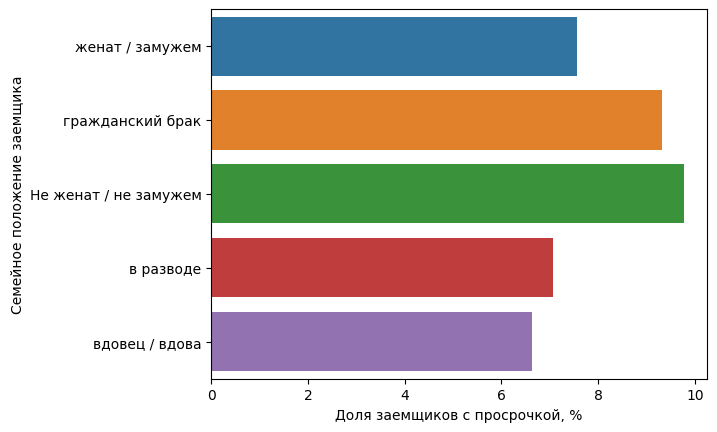

In [23]:
# получим сводные данные, отсортированные по количеству наблюдений:
pivot = (data.pivot_table(values='debt',index='family_status',aggfunc=['count','mean']).
         sort_values(('count', 'debt'), ascending=False))

# создадим таблицу для визуализации:
debt_by_family = pd.DataFrame(index=pivot.index)
debt_by_family['Семейное положение заемщика'] = pivot.index
debt_by_family['Кол-во наблюдений'] = pivot['count']
debt_by_family['Доля заемщиков с просрочкой, %'] = round(pivot['mean']*100, 3)
display(debt_by_family.reset_index(drop=True))

# рассмотрим распределение полученных значений:
sbn.barplot(x='Доля заемщиков с просрочкой, %', 
            y='Семейное положение заемщика', 
            data=debt_by_family);

Согласно данным в выборке:

- Преимущественно кредит берут люди в официальном браке (ок. 60% наблюдений). Вторая крупнейшая категория заемщиков - люди в гражданском браке.

- Наибольшая доля заемщиков, имеющих просрочку по кредиту, характерна для неженатых/незамужних заемщиков, что подтверждает гипотезу.

- С другой стороны, доля просрочек среди заемщиков в гражданском браке (9,3%) ближе к показателю неженатых/незамужних (9,7%), чем к заемщиков в официальном браке (ок. 7,6%), что противоречит выдвинутой гипотезе. Доли заемщиков с просрочкой среди разведенных и вдовцов также ниже, чем среди женатых/замужних (7% и 6,6% соответственно против 7,5%). Для объяснения таких наблюдений нужны дополнительные данные (например, переходит ли долг умершего партнера на наследников, которые становятся созаемщиками, остается ли бывший супруг/-а созаемщиком при расторжении брака и т.д.)


**Вывод:** 

Исходя из полученных данных, наибольшая вероятность допустить просрочку по кредиту у неженатых / незамужних заемщиков, однако прямая зависимость между семейным положением и возвратом кредита в срок не очевидна.

### Зависимость между уровнем дохода и возвратом кредита в срок

**Гипотеза**

Вероятность возврата кредита в срок должна быть тем выше, чем выше уровень дохода заемщика, т.к. доля расходов на базовые потребности (еда, жилье, одежда и т.д.) сокращается по мере роста дохода, а доля расходов на развлечения, товары роскоши и т.п. растет. Т.е. "окно" для перераспределения бюджета в пользу погашения кредита увеличивается по мере роста дохода.

**Анализ**

Для начала рассмотрим распределение уровня доходов заемщиков в выборке:

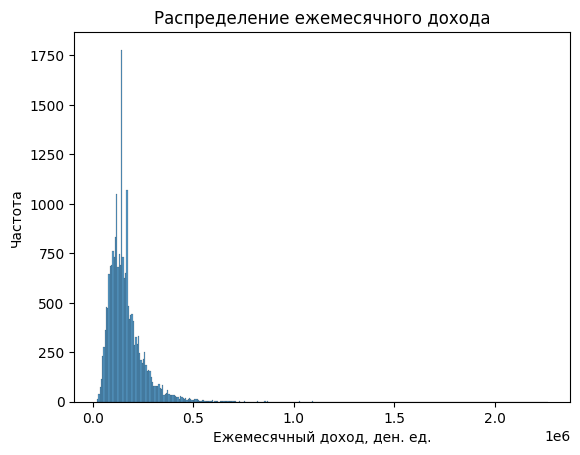

In [24]:
# выводим на экран результат:
sbn.histplot(data=data, x='total_income')
plt.xlabel('Ежемесячный доход, ден. ед.')
plt.ylabel('Частота')
plt.title('Распределение ежемесячного дохода');

Видим, что есть выбросы, однако в текущем виде график плохо читаем, поэтому покажем укрупненно участок с выбросами:

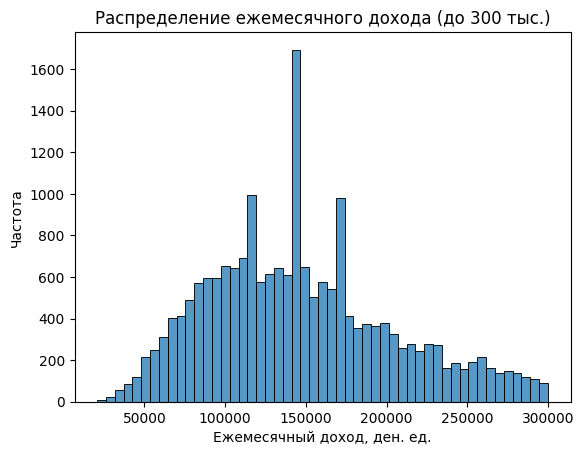

In [25]:
sbn.histplot(data=data[data['total_income'] <= 300000], 
             x='total_income')
plt.xlabel('Ежемесячный доход, ден. ед.')
plt.ylabel('Частота')
plt.title('Распределение ежемесячного дохода (до 300 тыс.)');

Видим, что в распределении доходов в выборке присутствуют явные выбросы, полученные при заполнении пропусков медианными значениями, все выбросы находятся в пределах от 100 до 200 тыс.ед. ежемесячного дохода.

За исключением выбросов, доходы заемщиков распределены равномерно.

Теперь перейдем к рассмотрению доли заемщиков с просрочкой по кредиту в зависимости от категории платежеспособности:

,Категория платежеспособности заемщика,Кол-во наблюдений,"Доля заемщиков с просрочкой, %"
0,A,25,8.000
1,B,5013,7.062
2,C,15921,8.498
3,D,349,6.017
4,E,22,9.091


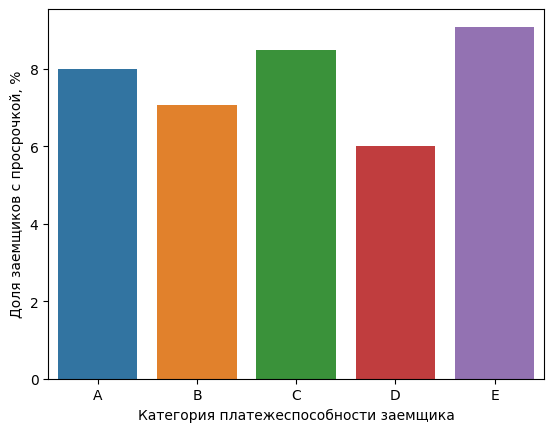

In [26]:
# получим сводные данные:
pivot = data.pivot_table(values='debt',index='total_income_category',aggfunc=['count','mean'])

# создадим таблицу для визуализации:
debt_by_income = pd.DataFrame(index=pivot.index)
debt_by_income['Категория платежеспособности заемщика'] = pivot.index
debt_by_income['Кол-во наблюдений'] = pivot['count']
debt_by_income['Доля заемщиков с просрочкой, %'] = round(pivot['mean']*100, 3)
debt_by_income = debt_by_income.sort_values('Категория платежеспособности заемщика').reset_index(drop=True)
display(debt_by_income)

# рассмотрим распределение полученных значений:
sbn.barplot(x='Категория платежеспособности заемщика', 
            y='Доля заемщиков с просрочкой, %', 
            data=debt_by_income);

- Видим, что основную массу наблюдений составляют заемщики с доходом от 50 до 200 тыс.ед./месяц (категория С, более 70% наблюдений, из них ок. 2 000 наблюдений - заполненные искусственно пропуски) и люди с доходом от 200 тыс. до 1 млн ед. в месяц (категория B, более 20% наблюдений). Доли наиболее бедных заемщиков (ежемесячный доход менее 30 тыс.ед.) и наиболее богатых заемщиков (более 1 млн ед. в месяц) несущественны.

- Тенденция на снижение доли просрочки наблюдается на заемщиках категории E (наиболее бедные заемщики, максимальная вероятность просрочки по категориям), С и A. Однако доли просрочки по заемщикам категорий D и B находятся ниже воображаемой линии тренда, построенной по категориям Е, С и А (см. график выше).

- С другой стороны, репрезентативными категориями являются только категории С и В (доля остальных категорий в совокупности не превышает 2%). Соответсвенно, данные по категориям E, D и A могут быть ненадежными. При сравнении репрезентативных категорий видно, что доля просрочки у более платежеспособной группы заметно ниже, чем у менее платежеспособной (ок. 7% для категории В против ок. 8,5% для категории С).

Можно проверить последний вывод, переопределив категории платежеспособности заемщиков (т.к. распределение доходов за исключением выбросов равномерно, а все выбросы попали в одну категорию, количество наблюдений в той или иной категории определяется применяемой группировкой).

,Категория платежеспособности заемщика,Кол-во наблюдений,"Доля заемщиков с просрочкой, %"
0,1) до 100 тыс.,4444,7.966
1,2) от 100 до 200 тыс.,11848,8.626
2,3) от 200 до 400 тыс.,4510,7.206
3,4) более 400 тыс.,528,5.871


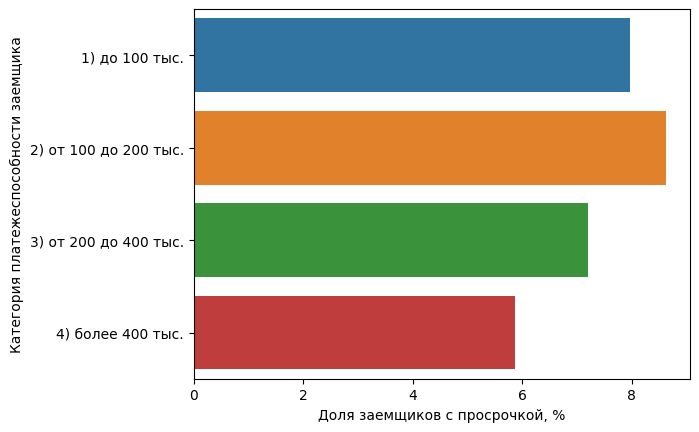

In [27]:
# создадим функцию для новой группировки по уровню дохода:
def new_income_category(income):
    if income <= 100000:
        return '1) до 100 тыс.'
    elif 100001 <= income <= 200000:
        return '2) от 100 до 200 тыс.'
    elif 200001 <= income <= 400000:
        return '3) от 200 до 400 тыс.'
    else:
        return '4) более 400 тыс.'

# применим функцию к данным:
data['total_income_category_new'] = data['total_income'].apply(new_income_category)

# получим сводные данные:
pivot = data.pivot_table(values='debt',index='total_income_category_new',aggfunc=['count','mean'])
# создадим таблицу для визуализации:
debt_by_income_new = pd.DataFrame(index=pivot.index)
debt_by_income_new['Категория платежеспособности заемщика'] = pivot.index
debt_by_income_new['Кол-во наблюдений'] = pivot['count']
debt_by_income_new['Доля заемщиков с просрочкой, %'] = round(pivot['mean']*100, 3)
debt_by_income_new = debt_by_income_new.reset_index(drop=True)
display(debt_by_income_new)

# рассмотрим распределение полученных значений:
sbn.barplot(x='Доля заемщиков с просрочкой, %', 
            y='Категория платежеспособности заемщика', 
            data=debt_by_income_new);

- Новая группировка дает менее концентрированное распределение наблюдений по категориям (даже с учетом того, что все пропуски в изначальных данных попали в категорию 2).

- Видим, что гипотеза подтверждается на всех категориях, кроме первой (доля просрочки у заемщиков с доходом до 100 тыс.ед. (ок. 8%) ниже, чем у заемщиков с доходом от 100 до 200 тыс.ед. (ок. 8,6%).Однако затем наблюдается явная тенденция к снижению доли просрочки при росте дохода. 

**Вывод**

Зависимость между уровнем дохода заемщика и возвратом кредита в срок есть, но она не линейная. Согласно данным, вероятность погашения кредита в срок у заемщиком с доходом до 100 тыс.ед. несколько выше, чем у следующей по уровню дохода категории, хотя в дальнейшем вероятность погашения в срок растет с уровнем дохода. Возможно, это объясняется дополнительными требованиями банка к заемщикам с наименьшим уровнем дохода (например, привлечение поручителей - для анализа нужны дополнительные данные).

### Зависимость между целью кредита и возвратом в срок

**Гипотеза**

Зависимости между целями кредита и вероятностью возврата в срок не должно быть, т.к. возможность вовремя вносить плату скорее определяется соотношением доходов и расходов заемщика, нежели направлением использования заемных средств. Обеспеченность кредита залогом (недвижимость, автомобиль и т.п.) в данном случае не является фактором, увеличивающим вероятность погашения в срок, т.к. истребование залога уже свидетельствует о просрочке платежа.

**Анализ**

,Цель кредита,Кол-во наблюдений,"Доля заемщиков с просрочкой, %"
0,операции с недвижимостью,10750,7.256
1,операции с автомобилем,4279,9.348
2,получение образования,3988,9.253
3,проведение свадьбы,2313,7.912


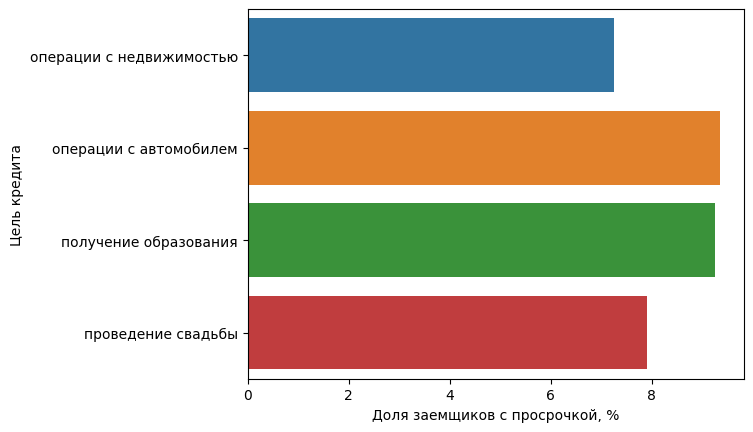

In [28]:
# получим сводные данные, отсортированные по количеству наблюдений:
pivot = (data.pivot_table(values='debt',index='purpose_category',aggfunc=['count','mean']).
         sort_values(('count', 'debt'), ascending=False))

# создадим таблицу для визуализации:
debt_by_purpose = pd.DataFrame(index=pivot.index)
debt_by_purpose['Цель кредита'] = pivot.index
debt_by_purpose['Кол-во наблюдений'] = pivot['count']
debt_by_purpose['Доля заемщиков с просрочкой, %'] = round(pivot['mean']*100, 3)
display(debt_by_purpose.reset_index(drop=True))

# рассмотрим распределение полученных значений:
sbn.barplot(x='Доля заемщиков с просрочкой, %', 
            y='Цель кредита', 
            data=debt_by_purpose);

- Около 50% кредитов выдаются на операции с жилой и коммерческой недвижимостью (в т.ч. ремонт помещений). Вторая по численности категория - операции с автомобилем (ок. 20%). 

- Наибольшая доля просрочек наблюдается по кредитам, выданным на операции с автомобилем (9,35%) и на получение образования (9,25%). Наименьшая - по кредитам на операции с недвижимостью (7,26%). Возможно, на такое распределение влияют косвенные факторы (напр., бОльшая доля заемщиков, приобретающих жилье, находятся в официальном браке, сроки кредитов и применяемые ставки (ипотечные кредиты обычно выдаются под меньший процент и на более долгий период), какие-то другие неочевидные причины).

**Вывод:**
Очевидная зависимость между целью кредита и вероятность вернуть заем в срок не наблюдается.

## Общий вывод

Цель проекта состояла в установлении зависимостей между характеристиками клиента банка (семенйное положение, наличие детей, уровень дохода и т.п.) и фактом погашения кредита в срок. Полученные выводы могут быть использованы при построении модели кредитного скоринга.

Для анализа была предоставлена выборка из 21,5 тыс.наблюдений. Данные были подготовлены к анализу:
- пропуски в колонках с общим трудовым стажем и ежемесячным доходом (ок. 10% от выборки) были заполнены медианными значениями для каждого типа занятости;
- устранены аномалии в данных (отрицательные значения стажа переведены в абсолютные значения, удалены подозрительные значения в колонках с количеством детей и полом клиента);
- устранены неявные дубликаты в написании уровня образования и явные дубликаты в выборке;
- введены категории для уровня дохода и цели кредита для упрощения анализа.

Исходя из предоставленных данных, можно выделить следующие наблюдения:

- Вероятноть погашения кредита в срок выше у бездетных заемщиков, чем у заемщиков с детьми. Однако распределение доли просрочки в зависисмости от *количества* детей у заемщика не приводит к однозначным выводам.
- Наибольший риск просрочки по кредиту наблюдается среди неженатых / незамужних заемщиков, но показатели просрочки по другим видам семейного положения не позволяют утверждать, что земщики-"одиночки" в целом хуже выплачивают кредит.
- Зависимость между уровнем дохода и долей просрочек нелинейная - вероятность погашения кредита в срок у заемщиком с доходом до 100 тыс.ед. несколько выше, чем у следующей по уровню дохода категории, хотя в дальнейшем вероятность погашения в срок растет с уровнем дохода. Возможно, это объясняется дополнительными требованиями банка к заемщикам с наименьшим уровнем дохода (например, привлечение поручителей - для анализа нужны дополнительные данные).
- Доля просрочек среди кредитов, взятых на приобретение автомобиля и получение образования выше, чем для кредитов на покупку недвижимости и проведение свадьбы, однако причины неясны.

Для дальнейшего анализа желательно выяснить, являются ли факторы независимыми (возможно, количество детей и семейное положение заемщика коррелирует с уровнем дохода, уровень дохода - с уровнем образования и т.п.), провести статистические тесты и/ли построить прогнозную модель для более точного ответа на поставленные вопросы.